In [217]:
import numpy as np
import matplotlib.pyplot as plt
import random
np.random.seed(42)
#matplotlib inline

# Các lớp biểu diễn

In [218]:
#-------------------------------------------------------------------------------
# Lớp biểu diễn các toạ độ (x, y)
#-------------------------------------------------------------------------------
class Position:
    # Constructor
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __str__(self):
        return f"({self.x}, {self.y})"
#-------------------------------------------------------------------------------
# Lớp biểu diễn các ô
#-------------------------------------------------------------------------------
class Cell: ## This class represent a state
    # Constructor
    def __init__(self, position: Position, status: str = 'free', g: float = 0, parent: list = [],  h: float = 0, f: float = 0):
        self.position = position # (x, y)
        self.parent   = parent   # parent (object) in a path
        self.status   = status   # {'free', 'start', 'dirty', 'clean'}
        
        self.g        = 1 if self.status == 'dirty' else 0  # current   cost #move cost
        self.h        = h # estimated cost
        # self.costdirty = 1 if status == 'dirty' else None
        self.f        = f #fullpathcost
    #---------------------------------------------------------------------------

    def fullpathcost(self):
        return self.f
    
    def __str__(self):
        return (self.position.x, self.position.y)
    

In [219]:
class VacuumProblem():
    # Constructor
    def __init__(self, matrix: list, robot_inital: Cell, initial_state: list[Cell], heufunc: str = 'Euclid'):
        self.matrix = matrix
        self.robot_inital = robot_inital
        self.initial_state = initial_state ##position of dirty cells
        self.numdirty = len(self.initial_state)
        self.heufunc = heufunc
        
    def is_goal(self) -> bool: #done testing
        '''Return True if all dirty cells are cleaned and No otherwise'''
        if self.numdirty == 0:
            return True
        else:
            return False
    
    def actions(self, state: Cell) -> str|list: #done testing
        '''Return a list of possible actions'''
        move = ['Up', 'Down', 'Left', 'Right', 'LeftUp', 'RightUp', 'LeftDown', 'RightDown']
        impossible = []
        m, n = len(self.matrix), len(self.matrix[0])

        if state.position.x == 0 and state.position.y in range(0,n): ##First row 
            if state.position == (0,0):
                impossible = ['Left', 'Up', 'LeftDown', 'RightUp']
            elif state.position == (0, n-1):
                impossible = ['Up', 'LeftUp', 'RightUp', 'RightDown']
            else:
                impossible = ['Up', 'LeftUp', 'RightUp']

        elif state.position.x == (m - 1) and state.position.y in range(0, n): ##Last row
            if state.position == (m, 0):
                impossible = ['Left', 'Down', 'LeftUp', 'LeftDown', 'RightDown']
            elif state.position == (m-1, n-1):
                impossible = ['RightUp', 'LeftDown', 'Down', 'RightDown']
            else:
                impossible = ['Down', 'LeftDown', 'RightDown']


        elif state.position.y == 0 and state.position.x in range(1, m-1): #First column
            impossible = ['Left', 'LeftDown', 'LeftUp']

        elif state.position.y == (n-1) and state.position.x in range(1, m-1): ##Last column
            impossible = ['Right', 'RightUp', 'RightDown']

        if state.status == 'dirty':
            return 'Suck'
        elif len(impossible) != 0:
            for im_act in impossible:
                move.remove(im_act)
            return move
        else:
            return move
   
    def result(self, state: Cell, action: str) -> Cell: #done testing
        '''Return a new state after applying an action'''
        # newstate = state
        # Create new position object
        new_position = Position(state.position.x, state.position.y)
        # Create new state with the new position
        newstate = Cell(position=new_position, status=state.status, g=state.g)
        if action == 'Suck':
        # if state.status == 'dirty' and action == 'Suck':
            newstate.status = 'clean'
            # newstate.g += 1 ##Cost of suck
            self.numdirty -= 1 ##only calculate g(n) cost
            return newstate

        else:
            # for act in action:  ##only calculate g(n) cost
            if action == 'Up':
                newstate.position.x -= 1
            elif action == 'Down':
                newstate.position.x += 1
            elif action == 'Left':
                newstate.position.y -= 1
            elif action == 'Right':
                newstate.position.y += 1

            elif action == 'LeftUp':
                newstate.position.x -= 1
                newstate.position.y -= 1
            elif action == 'LeftDown':
                newstate.position.x += 1
                newstate.position.y -= 1
            elif action == 'RightUp':
                newstate.position.x -= 1
                newstate.position.y += 1
            elif action == 'RightDown':
                newstate.position.x += 1
                newstate.position.y += 1
            # newstate.g += 1
            newstate.parent.append(state)
            return newstate
                
    
    def heuristic(self, state: Cell, othercell: Cell) -> float:
        '''Return heuristic cost between a cell and other cell'''
        if self.heufunc == 'Euclid':  ##Eucledian
            return ((state.position.x - othercell.position.x)**2 + (state.position.y - othercell.position.y)**2)**(1/2)
        elif self.heufunc == 'Manhattan':
            return abs(state.position.x - othercell.position.x) + abs(state.position.y - othercell.position.y)
        elif self.heufunc == 'Chebyshev':
            return max(abs(state.position.x - othercell.position.x), abs(state.position.y - othercell.position.y))
        
    
    # def dirty2clean(self, state: Cell, otherdirty: list[Cell]):
    #     "Choose the next dirty cell to be cleaned"
    #     result = None
    #     for dirty in otherdirty:



# Algorithm

In [220]:
def astar(problem: VacuumProblem): 
    """
    A* algorithm for vacuum cleaner problem
    Returns the path taken by the robot and total cost
    """
    robot = problem.robot_inital
    dirtycells = problem.initial_state
    total_cost = 0
    cleanedcells = []
    path = []

    while len(dirtycells) != 0:

        #Choose the nearest dirty cell
        dirty_min = float('inf')
        nearest_dirty = None
        for dirty in problem.initial_state:
            cost = robot.g + problem.heuristic(robot, dirty) 
            if cost < dirty_min:
                dirty_min = cost
                nearest_dirty = dirty
                
        #Find possible actions
        if (robot.position.x == nearest_dirty.position.x) and (robot.position.y == nearest_dirty.position.y):
            possible_acts = 'Suck'
        else:
            possible_acts = problem.actions(robot)  

        #Find best move
        bestact = None
        if isinstance(possible_acts, list): ##Not at the dirty cell
            action_min = float('inf')
            for action in possible_acts:
                newstate = problem.result(robot, action)
                cost = newstate.g + problem.heuristic(newstate, nearest_dirty) #moving cost and heuristic cost
                if cost < action_min:
                    action_min = cost
                    bestact = action
        else:
            bestact = 'Suck'
        
        #Do the action
        if bestact == 'Suck':
            cleaned = problem.result(nearest_dirty, bestact)
            cleanedcells.append(cleaned)
            robot.g += 1
            robot.g += nearest_dirty.g  #cost of sucking
            total_cost += 1 + nearest_dirty.g + 1 #first operand is for sucking, second is for cost of dirty cells and the third has cost 1 because of 'nearest_dirty.g is 0" for some reasons i don't know
            dirtycells.remove(nearest_dirty)
            path.append((bestact, (robot.position.x, robot.position.y)))
        else: 
            robot = problem.result(robot, bestact) #moving
            robot.g += 1  #moving cost
            robot.h += problem.heuristic(robot, nearest_dirty)
            robot.f += robot.g + robot.h
            total_cost += 1 + problem.heuristic(robot, nearest_dirty)
            path.append((bestact, (robot.position.x, robot.position.y)))
        #Update the cost of to-be-cleaned dirty cells
        for remain in dirtycells:
            remain.g += 1
    
    return path, total_cost#, cleanedcells

# Visualisation

In [221]:
 # Tạo ma trận với các ô bẩn ngẫu nhiên
def create_grid(m: int, n: int, num_dirty:int)-> tuple[list[Cell], Cell, list[Cell], list[Cell]]: 
    grid = [[Cell(Position(i, j)) for j in range(n)] for i in range(m)]
    dirty_cells = []
    dirty_cells_vi = []

    # Đặt ngẫu nhiên các ô bẩn
    for _ in range(num_dirty):
        x, y = np.random.randint(0, m-1), np.random.randint(0, n-1)
        while grid[x][y].status == 'dirty': ##If random at the dirty cell that is already exists, random again
            x, y = np.random.randint(0, m-1), np.random.randint(0, n-1)
        grid[x][y].status = 'dirty'
        dirty_cells.append(grid[x][y])
        dirty_cells_vi.append(grid[x][y])

    # Đặt vị trí bắt đầu ngẫu nhiên
    start_x, start_y = np.random.randint(0, m-1), np.random.randint(0, n-1) #if random at the dirty cell what will happen?
    while grid[start_x][start_y].status == 'dirty':
        start_x, start_y = np.random.randint(0, m-1), np.random.randint(0, n-1)
    grid[start_x][start_y].status = 'start'
    start = grid[start_x][start_y]
    
    return grid, start, dirty_cells, dirty_cells_vi


In [222]:
def mapping_path_text(path: list[tuple[str, tuple]]) -> list[tuple[str, tuple]]:
    result = []
    for action_coord in path:
        action_coord = list(action_coord) #Change tuple into a list for assignment operations
        action_coord[1] = list(action_coord[1])
        result.append(action_coord)
        
    for action_coord in result:
        if action_coord[0] == 'Up':
            action_coord[0] = 'Down'

        elif action_coord[0] == 'Down':
            action_coord[0] = 'Up'

        elif action_coord[0] == 'LeftDown':
            action_coord[0] = 'LeftUp'

        elif action_coord[0] == 'LeftUp':
            action_coord[0] = 'LeftDown'

        elif action_coord[0] == 'RightUp':
            action_coord[0] = 'RightDown'

        elif action_coord[0] == 'RightDown':
            action_coord[0] = 'RightUp'
 
    return result

# Visualize lộ trình với matplotlib
def visualize__with_path(grid, vaccum_world: VacuumProblem, solution: list[tuple[str, tuple]], cost: float, m: int, n: int, dirty_cells_vi: list[Cell], start_cell: int):
    #Get the coordinates of the solution
    path = [action_coord[1] for action_coord in solution]
    # Tạo ma trận màu ban đầu và thiết lập màu trắng cho nền
    grid = np.ones((m, n, 3))  # Ma trận màu trắng (1, 1, 1)
    
    # Đặt màu cho các ô rác - xanh lá cây
    for cell in dirty_cells_vi:
        grid[cell.position.x, cell.position.y] = [176/255, 186/255, 164/255]  # Xanh lá cây

    # Đặt màu cho ô bắt đầu - xanh nước biển
    grid[start_cell.position.x, start_cell.position.y] = [0/255, 95/255, 105/255]  # UEH Blue

    # Đặt màu cho các ô trong đường đi của robot - vàng
    for coords in path:
        if coords not in dirty_cells_vi and coords != start_cell:
            grid[coords[0], coords[1]] = [242/255, 111/255, 51/255]  # UEH Orange


    # Vẽ ma trận bằng matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, origin='lower')

    # Thêm các đường lưới và nhãn tọa độ
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(-0.5, n, 1), labels=np.arange(1, n+2, 1))
    plt.yticks(np.arange(-0.5, m, 1), labels=np.arange(1, m+2, 1))
    plt.gca().set_xticks(np.arange(0.5, n, 1), minor=True)
    plt.gca().set_yticks(np.arange(0.5, m, 1), minor=True)
    plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    # Đánh dấu tọa độ các ô rác và ô bắt đầu
    plt.text(start_cell.position.y, start_cell.position.x, 'Start', ha='center', va='center', color='black', fontsize=12, weight='bold')
    for cell in dirty_cells_vi:
        plt.text(cell.position.y, cell.position.x, 'C', ha='center', va='center', color='black', fontsize=12, weight='bold')

    # Thêm tiêu đề và hiển thị kết quả
    plt.title("Robot Cleaning Path Visualization")
    # plt.text(m, n, f'Total Cost: {cost:.2f}',
    #          ha='center', va='center', color='black', fontsize=12)
    plt.text(m-0.5, n-3, f'Total Path Cost: {cost:.2f} \n Heuristic Function: {vaccum_world.heufunc}',
         ha='center', va='center',
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.8'),
         color='black', fontsize=9, weight='bold')
    
    # plt.subplots_adjust(bottom=0.15)

    plt.axis('on')
    plt.show()

def visualize__initial(grid, m: int, n: int, dirty_cells_vi: list[Cell], start_cell: int):

    # Tạo ma trận màu ban đầu và thiết lập màu trắng cho nền
    grid = np.ones((m, n, 3))  # Ma trận màu trắng (1, 1, 1)
    
    # Đặt màu cho các ô rác - xanh lá cây
    for cell in dirty_cells_vi:
        grid[cell.position.x, cell.position.y] = [176/255, 186/255, 164/255]  # Xanh lá cây

    # Đặt màu cho ô bắt đầu - xanh nước biển
    grid[start_cell.position.x, start_cell.position.y] = [0/255, 95/255, 105/255]  # UEH Blue


    # Vẽ ma trận bằng matplotlib
    plt.figure(figsize=(8, 8))
    plt.imshow(grid, origin='lower')

    # Thêm các đường lưới và nhãn tọa độ
    plt.grid(color='black', linestyle='-', linewidth=0.5)
    plt.xticks(np.arange(-0.5, n, 1), labels=np.arange(1, n+2, 1))
    plt.yticks(np.arange(-0.5, m, 1), labels=np.arange(1, m+2, 1))
    plt.gca().set_xticks(np.arange(0.5, n, 1), minor=True)
    plt.gca().set_yticks(np.arange(0.5, m, 1), minor=True)
    plt.gca().grid(which='minor', color='black', linestyle='-', linewidth=0.5)

    # Đánh dấu tọa độ các ô rác và ô bắt đầu
    plt.text(start_cell.position.y, start_cell.position.x, 'Start', ha='center', va='center', color='black', fontsize=12, weight='bold')
    for cell in dirty_cells_vi:
        plt.text(cell.position.y, cell.position.x, 'D', ha='center', va='center', color='black', fontsize=12, weight='bold')

    # Thêm tiêu đề và hiển thị kết quả
    plt.title("Robot Cleaning Path Visualization - Initial")
    

    plt.axis('on')
    plt.show()


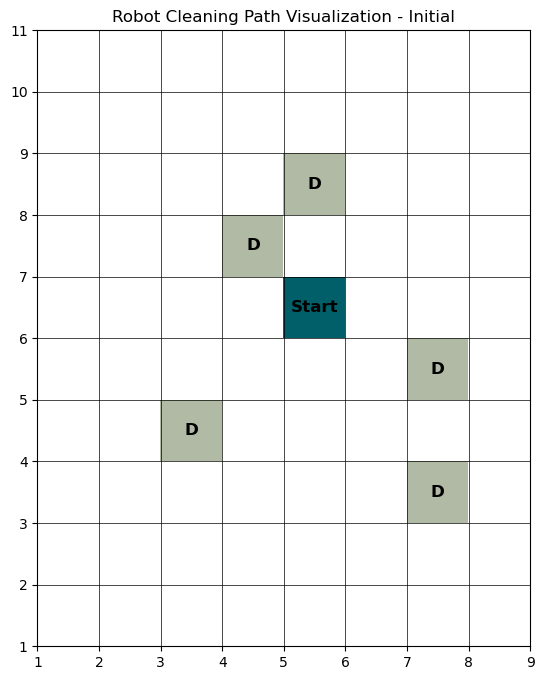

In [223]:
m = int(input("Nhập số hàng (m): ")) 
n = int(input("Nhập số cột (n): ")) 
num_dirty = int(input("Nhập số lượng ô bẩn: "))

grid, start_cell, dirty_cells, dirty_cells_vi = create_grid(m, n, num_dirty)
vacuum_world = VacuumProblem(grid, start_cell, dirty_cells, heufunc='Chebyshev')
solution, cost = astar(vacuum_world)
solution = mapping_path_text(solution)

visualize__initial(grid, m, n, dirty_cells_vi, start_cell)

Lộ trình robot đi qua:
['(LeftUp, (7, 4))', '(Suck, (7, 4))', '(RightUp, (8, 5))', '(Suck, (8, 5))', '(Down, (7, 5))', '(RightDown, (6, 6))', '(RightDown, (5, 7))', '(Suck, (5, 7))', '(Down, (4, 7))', '(Down, (3, 7))', '(Suck, (3, 7))', '(Left, (3, 6))', '(Left, (3, 5))', '(Left, (3, 4))', '(LeftUp, (4, 3))', '(Suck, (4, 3))']


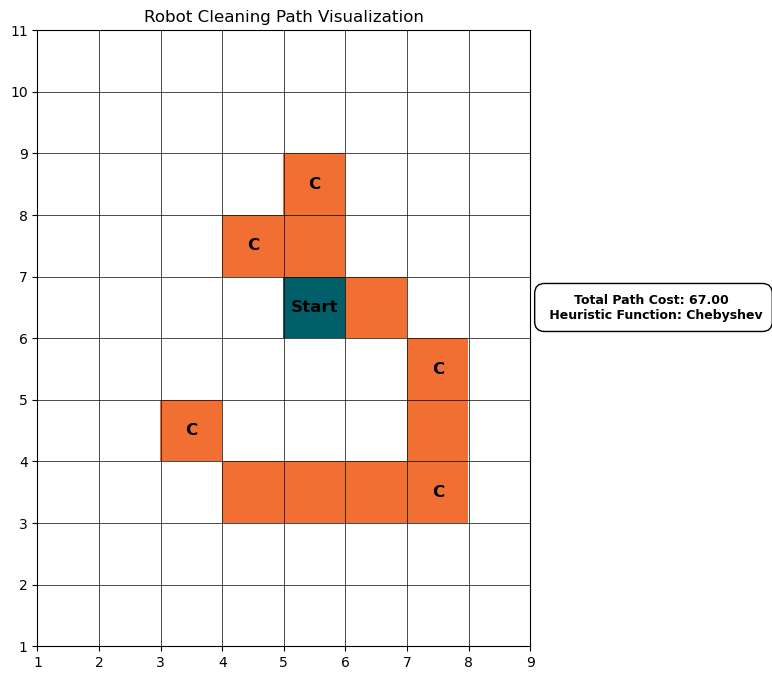

In [224]:
print("Lộ trình robot đi qua:")
print([f"({action_coord[0]}, ({action_coord[1][0]+1}, {action_coord[1][1]+1}))" for action_coord in solution])

visualize__with_path(grid, vacuum_world, solution, cost, m, n, dirty_cells_vi, start_cell)